# Data Elaboration Notebook

In [1]:
import requests
import pandas as pd
import xml.etree.ElementTree as ET
import json
import html
import multiprocessing
from collections import Counter
from bs4 import BeautifulSoup
from pathlib import Path
from googleapiclient import discovery
import os, glob
import time
from googleapiclient.errors import HttpError
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import collections as matcoll
import re

## Processing of each scraped account and scoring of their posts

In [2]:
with open('./apikey.txt') as api_file: 
    API_KEY = api_file.read()
    
API_CLIENT = api_client = discovery.build(
    "commentanalyzer",
    "v1alpha1",
    developerKey=API_KEY,
    discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
    static_discovery=False)

In [3]:
def query_perspective(text, languages = None):
    '''
    This methods takes as inputs:
    [text] - content to feed to Perspective API\\
    [languages] - set of languages to ask Perspective to run the analysis on. In case this is not specified, language detection will be used.\\
    
    It ouputs:\\
    A JSON object containing scores of currently tested and so non-experimental categories on Perspective.\\
    We leave you to documentation for more details
    '''
    analyze_request = {
        'comment': { 'text': text },
        'requestedAttributes': {'TOXICITY': {}, 'SEVERE_TOXICITY': {}, 'IDENTITY_ATTACK' : {}, 'INSULT': {}, 'PROFANITY' : {}, 'THREAT' : {}}
    }
    if(languages):
        analyze_request['languages'] = languages
    try :
        # query perspective
        response = API_CLIENT.comments().analyze(body=analyze_request).execute()
    except (Exception,HttpError) as err:
        if (type(err) == HttpError):
            # in case we catch 429 status code erros, than rate limiter has been reached. sleep and restart
            if (err.status_code == 429):
                time.sleep(61)
                return query_perspective(text=text, languages = languages)
            elif(err.status_code == 400):
                return None
        else :
            print("Catched an exception not dealt with.. we will print and then sleep and resume after 61 seconds. ")
            print("Exception : ")
            print(err)
            print("Skipping to next")
            return None
    return response['attributeScores']


In [5]:
'''
with open('./scores.csv', 'w+') as scores_file :
    scores_file.write('twitter_username,mastodon_username,Twitter_TOXICITY,Twitter_SEVERE_TOXICITY,Twitter_IDENTITY_ATTACK,Twitter_INSULT,Twitter_PROFANITY,Twitter_THREAT,Mastodon_TOXICITY,Mastodon_SEVERE_TOXICITY,Mastodon_IDENTITY_ATTACK,Mastodon_INSULT,Mastodon_PROFANITY,Mastodon_THREAT')
'''

In [5]:
def process_users_scores(twitter_username, mastodon_username):
    print(f"Processing {twitter_username}")
    # Example mastodon user : https://techhub.social/@nateplusplus
    # extract mastodon server name  
    mastodon_server = mastodon_username.split('https://')[1].split('/@')[0]
    # extract mastodon user name
    mastodon_user = mastodon_username.split('/@')[-1].split('/')[0]
    # build folder name as we constructed it before
    mastodon_folder = mastodon_server+'_'+mastodon_user
    
    # 1. extract tweets
    try:
        tweets = glob.glob(f"./tweets/{twitter_username}/*.json")
        # 2. extract mastodon posts
        mastodon_posts = glob.glob(f"./mastodon_posts/{mastodon_folder}/*.json")
        if(len(mastodon_posts) == 0 ):
            print("Not processing this user as it has no mastodon posts")
            return
    except:
        print(f"This user is not present in one of the two socials, going next.")
        return
    tweets_amount = len(list(tweets))
    mastodon_posts_amount = len(list(mastodon_folder))
    
    # define scores
    twitter_scores = []
    mastodon_scores = []
    
    languages = set()
    print("scoring Mastodon")
    # go through posts and query API
    for post in tqdm(mastodon_posts) :
        with open(post, 'r+') as post_file:
            post_json = json.load(post_file)
        text = post_json['content']
        languages.add(post_json['language'])
        
        scores = query_perspective(text=text, languages = list(languages))
        if(not scores):
            continue
        # append scores for each category
        mastodon_scores.append({
            'TOXICITY': scores['TOXICITY']['summaryScore']['value'],
                'SEVERE_TOXICITY': scores['SEVERE_TOXICITY']['summaryScore']['value'],
                'IDENTITY_ATTACK' : scores[ 'IDENTITY_ATTACK' ]['summaryScore']['value'],
                'INSULT': scores['INSULT']['summaryScore']['value'],
                'PROFANITY' : scores[ 'PROFANITY' ]['summaryScore']['value'],
                'THREAT' : scores[ 'THREAT' ]['summaryScore']['value']
        })
          
    # do the same for twitter
    print("scoring Twitter")  
    for tweet in tqdm(tweets) :
        with open(tweet, 'r+') as tweet_file:
            tweet_json = json.load(tweet_file)
        text = tweet_json['text']

        scores = query_perspective(text=text, languages= list(languages))
        if(not scores):
            continue

        twitter_scores.append(
            {
            'TOXICITY': scores['TOXICITY']['summaryScore']['value'],
            'SEVERE_TOXICITY': scores['SEVERE_TOXICITY']['summaryScore']['value'],
            'IDENTITY_ATTACK' : scores['IDENTITY_ATTACK']['summaryScore']['value'],
            'INSULT': scores['INSULT']['summaryScore']['value'],
            'PROFANITY' : scores['PROFANITY']['summaryScore']['value'],
            'THREAT' : scores['THREAT']['summaryScore']['value']
        })
        
    # extract averages for each scores
    sums = Counter()
    counters = Counter()
    for itemset in mastodon_scores:
        sums.update(itemset)
        counters.update(itemset.keys())

    mastodon_score = {x: float(sums[x])/counters[x] for x in sums.keys()}

    sums = Counter()
    counters = Counter()
    for itemset in twitter_scores:
        sums.update(itemset)
        counters.update(itemset.keys())

    twitter_score = {x: float(sums[x])/counters[x] for x in sums.keys()}
    
    # output
    if(not (twitter_score.get('TOXICITY') and mastodon_score.get('TOXICITY')) ):
        return
    with open('./scores.csv', 'a+') as scores_file :
        scores_file.write(f"\n{twitter_username},{mastodon_folder},{twitter_score['TOXICITY']},{twitter_score['SEVERE_TOXICITY']},{twitter_score['IDENTITY_ATTACK']},{twitter_score['INSULT']},{twitter_score['PROFANITY']},{twitter_score['THREAT']},{mastodon_score['TOXICITY']},{mastodon_score['SEVERE_TOXICITY']},{mastodon_score['IDENTITY_ATTACK']},{mastodon_score['INSULT']},{mastodon_score['PROFANITY']},{mastodon_score['THREAT']}")
        

            

For each user present in the main csv we now process scores and save them in a txt to not recompute them each time.

In [20]:
users = pd.read_csv('./users.csv', delimiter=',', index_col=None)
with open('./users_processed.txt', 'r+') as users_processed_file :
    users_processed = users_processed_file.read().split(',')
    print(users_processed)
for idx, row in users.iterrows():
    if(row['twitter_username'] not in users_processed):
        process_users_scores(row['twitter_username'], row['mastodon_username'])
        with open('./users_processed.txt', 'a+') as users_processed_file :
            users_processed_file.write(f"{row['twitter_username']},")

['piesdeperro', 'gal_suburban', 'flowerofmemory', 'yungkiryu', 'ivanjuarezart', 'theunawarewolf', 'nateplusplus', 'jjhevel', 'gianpiero82', 'AbyssGrant', 'francoiseleste', 'TheDustyUno', 'EvilTurtleGames', 'Rauchz3ich3n', 'MyBlondeSpace', 'Schiracha', 'AlessioPao', 'wajlonis', 'Glitterbug825', 'bothness', 'Scott1984FP', 'KillerDread', 'pchowla', 'cisene', 'SolEnFlandes', 'pearcec', 'alimrod', 'sypianski', 'oLD_KaNuToR', 'CatMazikeen', 'SAMSONFLO', 'Bad_Journalist2', 'auntybumblebeez', 'adamrudy', 'mawedler2', '_dans_dans', 'Nacho_Rolero', 'Tenebris_Studio', 'padmanabhpv100', 'Vegemini', 'mattFalcor', 'SchoolingDiana', 'carlschroedl', 'AnagramWorld', 'rockienockie', 'TheSacredIsle', 'JohnMacGXxxx', 'GaiaFX_', 'cloudron_io', 'victorredman', 'JosephDavidAAA', 'XinoVld', 'Thistlesjewell1', 'TraciVanWagoner', 'Aussiemandias', 'mollyrcampbell', '359Papi', 'ross_macfarlane', 'NemchikEric', 'Pedro_GaLez', 'RowdyRabble', 'lux_de_lanferna', 'FattahMagazine', 'ImAwkwardGaymer', 'ZeroOne33408052',

Let's now sort scores by Toxicity in order to explore what the situation is..

In [28]:
scores = pd.read_csv('./scores.csv')

toxicity = scores[['twitter_username', 'mastodon_username', 'Twitter_TOXICITY', 'Mastodon_TOXICITY']]
#toxicity.sort_values('Twitter_TOXICITY', ascending=False)
toxicity.sort_values('Mastodon_TOXICITY', ascending=False)

,twitter_username,mastodon_username,Twitter_TOXICITY,Mastodon_TOXICITY
292,dkcrypto13,techhub.social_dkcrypto13,0.081141,0.535794
1,theunawarewolf,universeodon.com_theunawarewolf,0.135003,0.386850
123,BluejayPrime,universeodon.com_bluejayprime,0.232357,0.343215
9,Rauchz3ich3n,social.cologne_rauchz3ch3n,0.303436,0.289189
118,Privateer1,mstdn.ca_Privateer,0.138277,0.285490
...,...,...,...,...
235,OndesVitales,mastodon.free-solutions.org_odz,0.046804,0.003848
0,ivanjuarezart,tkz.one_ivanjuarezart,0.029129,0.003762
353,MPE_13,piaille.fr_MPE13,0.012812,0.003440
249,licca9shutsu,fedibird.com_licca9shutsu,0.044709,0.003199


In [29]:
insults = scores[['twitter_username', 'mastodon_username', 'Twitter_INSULT', 'Mastodon_INSULT']]
#insults.sort_values('Twitter_INSULT', ascending=False)
insults.sort_values('Mastodon_INSULT', ascending=False)

,twitter_username,mastodon_username,Twitter_INSULT,Mastodon_INSULT
123,BluejayPrime,universeodon.com_bluejayprime,0.228759,0.334765
292,dkcrypto13,techhub.social_dkcrypto13,0.051951,0.275582
138,writingwoman,literatur.social_writingwoman,0.189660,0.252164
325,Roessix,gruene.social_klaus,0.210261,0.246766
122,GatoBelicoCL,tkz.one_belicat,0.298297,0.243558
...,...,...,...,...
117,itzLPSlover,mastodon.social_LPSlover,0.022631,0.006344
0,ivanjuarezart,tkz.one_ivanjuarezart,0.019771,0.005998
226,opreismetco,mastodon.nl_opreismetco,0.007137,0.005947
249,licca9shutsu,fedibird.com_licca9shutsu,0.029575,0.005856


From what can be seen from this scores, top users in term of toxicity for one social network are not necessarily the top users in term of toxicity for the other!
Let's now go ahead and explore scores in a better way.

The better study can be found on the next notebook "Code_Analysis" which should be viewed before proceeding to the next section.

In [33]:
scores['Twitter_TOXICITY'].corr(scores['Mastodon_TOXICITY'])

0.5901796276356103

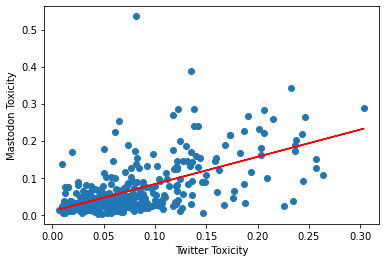

In [38]:
plt.scatter(x= scores['Twitter_TOXICITY'], y= scores['Mastodon_TOXICITY'])
plt.xlabel('Twitter Toxicity')
plt.ylabel('Mastodon Toxicity')
m, b = np.polyfit(scores['Twitter_TOXICITY'], scores['Mastodon_TOXICITY'], 1)

#add linear regression line to scatterplot 
plt.plot(scores['Twitter_TOXICITY'], m*scores['Twitter_TOXICITY']+b,color='red')

## Extraction for echo-chamber effect study

Here we keep on extracting data after having run its analysis on the notebook 
- ./Code_Analysis.ipynb

Now we move on by scraping followers to explore polarization of top 5% users in term of toxicity.

In [5]:
users = pd.read_csv('./users.csv')
df = pd.read_csv('./scores.csv')
df.head(7)

,twitter_username,mastodon_username,Twitter_TOXICITY,Twitter_SEVERE_TOXICITY,Twitter_IDENTITY_ATTACK,Twitter_INSULT,Twitter_PROFANITY,Twitter_THREAT,Mastodon_TOXICITY,Mastodon_SEVERE_TOXICITY,Mastodon_IDENTITY_ATTACK,Mastodon_INSULT,Mastodon_PROFANITY,Mastodon_THREAT
0,ivanjuarezart,tkz.one_ivanjuarezart,0.029129,0.002153,0.004220,0.019771,0.030770,0.006482,0.003762,0.000296,0.000682,0.005998,0.010410,0.005543
1,theunawarewolf,universeodon.com_theunawarewolf,0.135003,0.017387,0.020852,0.065664,0.100821,0.026605,0.386850,0.041872,0.097611,0.185161,0.324655,0.085338
2,nateplusplus,techhub.social_nateplusplus,0.076167,0.007537,0.013460,0.049011,0.055415,0.014735,0.022743,0.001666,0.004730,0.009837,0.017265,0.008505
3,jjhevel,writing.exchange_jhevel,0.041864,0.002179,0.005643,0.018268,0.027281,0.012124,0.038349,0.001734,0.007405,0.014560,0.022845,0.008757
4,gianpiero82,mastodon.uno_gianpiero82,0.088620,0.005518,0.019904,0.071827,0.049008,0.011217,0.078197,0.003559,0.014876,0.074080,0.044509,0.006781
5,AbyssGrant,socel.net_AbyssGrant,0.040816,0.002991,0.006459,0.015154,0.035685,0.012143,0.038240,0.001911,0.005614,0.015132,0.026440,0.008250
6,francoiseleste,mastodon.online_francoiseleste,0.237678,0.157053,0.230957,0.241538,0.160643,0.234195,0.201270,0.114238,0.178436,0.224116,0.144719,0.201732


In [6]:
#Divide the two distribution
tw = df.iloc[:, [0, 2,3,4,5,6,7]]
ma = df.iloc[:, [1,8,9,10,11,12,13]]

# Add a score variables as mean of the others score

tw['mean_score'] = tw[['Twitter_TOXICITY','Twitter_SEVERE_TOXICITY', 'Twitter_IDENTITY_ATTACK', 'Twitter_INSULT','Twitter_PROFANITY','Twitter_THREAT']].mean(axis=1)
ma['mean_score'] = ma[['Mastodon_TOXICITY','Mastodon_SEVERE_TOXICITY', 'Mastodon_IDENTITY_ATTACK', 'Mastodon_INSULT','Mastodon_PROFANITY','Mastodon_THREAT']].mean(axis=1)
tw['group'] = 'Twitter'
ma['group'] = 'Mastodon'

/var/folders/kr/4nryf1l96vgc2k_v0q8rvrpc0000gn/T/ipykernel_3758/365423177.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tw['mean_score'] = tw[['Twitter_TOXICITY','Twitter_SEVERE_TOXICITY', 'Twitter_IDENTITY_ATTACK', 'Twitter_INSULT','Twitter_PROFANITY','Twitter_THREAT']].mean(axis=1)
/var/folders/kr/4nryf1l96vgc2k_v0q8rvrpc0000gn/T/ipykernel_3758/365423177.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ma['mean_score'] = ma[['Mastodon_TOXICITY','Mastodon_SEVERE_TOXICITY', 'Mastodon_IDENTITY_ATTAC

In [7]:
df1 = tw.iloc[:, [7,8]]
df2 = ma.iloc[:, [7,8]]
distr = pd.concat([df1,df2],ignore_index= True)

In [26]:
#Extract  5% higher values
p = np.percentile(tw['mean_score'], 95) # return 50th percentile, e.g median.
print('twitter median: ', p)

big_tw = tw[tw['mean_score'] > p]

p = np.percentile(ma['mean_score'], 95) # return 50th percentile, e.g median.
print('mastodon median: ', p)

big_ma = ma[ma['mean_score'] > p]



twitter median:  0.12170909749309998
mastodon median:  0.1495698868816249


Extract common users

In [27]:
common_avg_ma = big_ma.index.intersection(big_tw.index) #14 are in common
common_avg_tw = big_tw.index.intersection(big_ma.index) #14 are in common
print('toxic users in common: ', len(common_avg_ma))

toxic users in common:  14


In [28]:
avg_toxic_users_ma_data = big_ma.loc[common_avg_ma]
avg_toxic_users_tw_data = big_tw.loc[common_avg_tw]


In [29]:
users['twitter_username'].values

array(['piesdeperro', 'gal_suburban', 'flowerofmemory', 'yungkiryu',
       'ivanjuarezart', 'theunawarewolf', 'nateplusplus', 'jjhevel',
       'gianpiero82', 'AbyssGrant', 'francoiseleste', 'TheDustyUno',
       'EvilTurtleGames', 'Rauchz3ich3n', 'MyBlondeSpace', 'Schiracha',
       'AlessioPao', 'wajlonis', 'Glitterbug825', 'bothness',
       'Scott1984FP', 'KillerDread', 'pchowla', 'cisene', 'SolEnFlandes',
       'pearcec', 'alimrod', 'sypianski', 'oLD_KaNuToR', 'CatMazikeen',
       'SAMSONFLO', 'Bad_Journalist2', 'auntybumblebeez', 'adamrudy',
       'mawedler2', '_dans_dans', 'Nacho_Rolero', 'Tenebris_Studio',
       'padmanabhpv100', 'Vegemini', 'mattFalcor', 'SchoolingDiana',
       'carlschroedl', 'AnagramWorld', 'rockienockie', 'TheSacredIsle',
       'JohnMacGXxxx', 'GaiaFX_', 'cloudron_io', 'victorredman',
       'JosephDavidAAA', 'XinoVld', 'Thistlesjewell1', 'TraciVanWagoner',
       'Aussiemandias', 'mollyrcampbell', '359Papi', 'ross_macfarlane',
       'NemchikEric', 

In [74]:
avg_toxic_users_tw_data['twitter_username']

6       francoiseleste
9         Rauchz3ich3n
23           mawedler2
34        victorredman
80            McWaffel
122       GatoBelicoCL
123       BluejayPrime
128    thedianatavares
138       writingwoman
182     CradleofEden83
225       derfeinekali
244        roschriften
296    MartinMsAccount
325            Roessix
Name: twitter_username, dtype: object

In [30]:
users = pd.read_csv('./users.csv', index_col=None)
avg_toxic_users = users.loc[users['twitter_username'].isin(avg_toxic_users_tw_data['twitter_username'])]

In [11]:
avg_toxic_users.head()

,twitter_username,twitter_id,mastodon_username
10,francoiseleste,121026820,https://mastodon.online/@francoiseleste/109332...
13,Rauchz3ich3n,1157616277269241862,https://social.cologne/@rauchz3ch3n
34,mawedler2,1253267702384406529,https://social.dev-wiki.de/@mawedler
49,victorredman,234757100,https://mas.to/@victorredman
103,McWaffel,46967537,https://social.cologne/@McWaffel


### Toxic Users

Here we process and extract scores of followers for our top 5% accounts in term of toxicity (for both social network).  
We proceed by asking twitter for each and everyone of the accounts' followers

In [1]:
bearer_token = "AAAAAAAAAAAAAAAAAAAAAC7IlAEAAAAAfoaln2kKYoXI8xiBWLl203J6zoM%3DuRNUzaVpXBPJYFcQTliOP0GpjyroT40TNdhG56jKfDTVatOB8O"

def query_user_followers(user_id : str):
    '''
    This methods takes in a [user_id], scrapes its twitter followers and saves them in a JSON file.
    '''
    followers = []
    try: 
        #request_url = f"https://api.twitter.com/1.1/followers/ids.json?cursor=-1&user_id={user_id}"
        request_url = f"https://api.twitter.com/2/users/{user_id}/followers?max_results=1000"
        headers = {'Authorization': f'Bearer {bearer_token}' }
        response = requests.get(request_url, headers=headers)
        
        if(response.json().get('errors') and response.json().get('errors')[0].get('title') == 'Not Found Error'):
                return None
        
        data = response.json().get('data')
        # if there is no data then check for errors
        
        if(not data):
            print(f"Error paginating more followers for user {user_id}.")
            print(response.json())
            if(response.json().get('status') == 429 or (response.json().get('errors') and response.json().get('errors')[0].get('code') == 88)  ):
                # sleep
                print('Rate limiter in use, waiting 15 minutes...')
                time.sleep((15* 60) + 1)
                # retry
                response = requests.get(request_url, headers=headers)
                data = response.json().get('data')
            else:
                return None
            
        
        # if we have data then process it
        for fol in data:
            followers.append({
                'id': fol['id'],
                'username': fol['username']
            })
        # check for pagination
        next_token = None # response.json().get('meta').get('next_token')
        page = 0
        while(next_token and page <= 5):
            page+= 1
            try:
                response = requests.get(f"{request_url}&pagination_token={next_token}", headers=headers)
                data = response.json().get('data')
                for fol in data:
                    followers.append({
                        'id': fol['id'],
                        'username': fol['username']
                    })
                next_token = response.json().get('meta').get('next_token')
            
            except:
                if(response.json().get('status') == 429 or (response.json().get('errors') and response.json().get('errors')[0].get('code') == 88)  ):
                    print("reached rate limiter, sleeping for 15 minutes")
                    time.sleep((15*60)+1)
                    print(f"resuming")
                    response = requests.get(f"{request_url}&pagination_token={next_token}", headers=headers)
                    data = response.json().get('data')
                    for fol in data:
                        followers.append({
                            'id': fol['id'],
                            'username': fol['username']
                        })
                    next_token = response.json().get('meta').get('next_token')
                else:
                    print(response.json())
                    break
            
        
    except:
        print(f"Couldn't reserve followers for user {user_id}\nException: {response.json()}")
        raise Exception()
        
    return followers
    
def query_mastodon_followers(mastodon_url):
    '''
    This methods takes in a [user_id], scrapes its mastodon followers and saves them in a JSON file.
    '''
    followers = []
    # 1. split information in "server" /@ "username" / rest...
    _mast_info = mastodon_url.split('/@')
    # 2. save both server and username, we will need them to query the api.
    try:
        mastodon_server = _mast_info[0]
        mastodon_username = _mast_info[1].split('/')[0]
        # every user on mastodon has an associated rss. This can be requested to scrape a user's ID
        request_url = f"{mastodon_server}/@{mastodon_username}.rss"
    except:
        _mast_info = _mast_info[0].split('/users')
        _mastodon_server = _mast_info[0]
        _mastodon_username = _mast_info[1].split('/')[0]
        request_url = f"{mastodon_server}/users/{mastodon_username}.rss"

    mastodon_rss_reponse = requests.get(request_url)
    # use an xml parser to extract the tag that contains our id
    id_pre = ET.fromstring(mastodon_rss_reponse.text).find('./channel/image/url')#.text.split('/')[-1]
    id = ''.join(id_pre.text.split('avatars/')[-1].split('/original')[0].split('/'))
    
    if(id == "originalmissing.png"):
        return None
    try:
        foll_request = f'{mastodon_server}/api/v1/accounts/{id}/followers'
        foll_response = requests.get(foll_request)
    except: 
        return None
    if(not isinstance(foll_response.json(), list) and foll_response.json().get('error') == 'The access token is invalid'):
        return None
    for fol in foll_response.json():
        follower = {
            'id': fol.get('id'),
            'url' : fol.get('url')
        }
        followers.append(follower)
    
    next_page = foll_response.headers.get('Link').split('>; rel="next"')[0].strip().replace('<', '') if (foll_response.headers.get('Link')) else None
    idx = 0
    # pagination
    while(next_page and idx <= 5):
        idx += 1
        foll_request = next_page
        
        foll_response = requests.get(foll_request)
        
        for fol in foll_response.json():
            follower = {
                'id': fol.get('id'),
                'url' : fol.get('url')
            }
            
            followers.append(follower)
        
        if(len(foll_response.json()) < 40): 
            break
        next_page = foll_response.headers.get('Link').split('>; rel="next"')[0].strip().replace('<', '') if (foll_response.headers.get('Link')) else None
        
    return followers
    

#### Fetch and save toxic followers data

first we create the folders

In [196]:
'''
os.mkdir('./toxic_accounts_followers')
os.mkdir('./toxic_accounts_followers/twitter')
os.mkdir('./toxic_accounts_followers/mastodon')
'''

here we query twitter to fetch followers of each one of our users in study, we then parse the followers list to a file

In [15]:
for idx, user in avg_toxic_users.iterrows():
    if(Path(f'./toxic_accounts_followers/twitter/{user["twitter_id"]}.json').is_file() ):
        print("file already exists..")
        continue
    results = query_user_followers(str(user['twitter_id']))
    print(f'User { user["twitter_username"] } has {len(results)} followers')
    with open(f'./toxic_accounts_followers/twitter/{user["twitter_id"]}.json', 'w+') as json_file:
        json.dump(results, json_file)
    
    
    

file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..


We then do the same thing with mastodon. Format is pretty much the same

In [280]:
for idx, user in avg_toxic_users.iterrows():
    
    if(Path(f'./toxic_accounts_followers/mastodon/{user["twitter_id"]}.json').is_file() ):
        print("file already exists..")
        continue
    results = query_mastodon_followers(str(user['mastodon_username']))
    if(not results):
        continue
    print(f'User { user["twitter_username"] } has {len(results)} followers on mastodon')
    
    with open(f'./toxic_accounts_followers/mastodon/{user["twitter_id"]}.json', 'w+') as json_file:
        json.dump(results, json_file)

file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
https://literatur.social/@writingwoman
User writingwoman has 695 followers on mastodon
https://troet.cafe/@freakazoid
User CradleofEden83 has 11 followers on mastodon
https://social.anoxinon.de/@derfeinekali
User derfeinekali has 245 followers on mastodon
https://sueden.social/@gruenehelden
User roschriften has 8 followers on mastodon
https://mastodon.world/@MartinMsAccount
User MartinMsAccount has 25 followers on mastodon
https://gruene.social/@klaus
User Roessix has 5 followers on mastodon


now we process followers and extract posts

In [109]:

def process_mastodon_profile(mastodon_url, save_path = None):
    '''
    This takes a mastodon profile url in input [mastodon_url] and scrapes its posts.\\
    We limit requests to one page to reduce volume of the analysis
    '''
    # 2. split information in "server" /@ "username" / rest...
    _mast_info = mastodon_url.split('/@')
    request_url = ''
    # 3. save both server and username, we will need them to query the api.
    try:
        mastodon_server = _mast_info[0]
        mastodon_username = _mast_info[1].split('/')[0]
    except: 
        #print(f"Exception on {_mast_info}")
        return False
    request_url = f"{mastodon_server}/@{mastodon_username}.rss"
    try:
        mastodon_rss_reponse = requests.get(request_url)
    except:
        #print(f"Most likely timedout")
        return False
    try:
        # use an xml parser to extract the tag that contains our id
        id_pre = ET.fromstring(mastodon_rss_reponse.text).find('./channel/image/url')#.text.split('/')[-1]
        id = ''.join(id_pre.text.split('avatars/')[-1].split('/original')[0].split('/'))
    except:
        #print(f"Error while working on ID for user {mastodon_url}.")
        #print(f"Likely it is from a strange element tree. we skip")
        return False
    if(id == "originalmissing.png"):
        #print(f"No id for current user {mastodon_url}")
        return False
    
    # we can now use this id to query mastodon's timeline public api !
    # example request -> https://mstdn.social/api/v1/accounts/109394907532170837/statuses
    api_request_url = f"{mastodon_server}/api/v1/accounts/{id}/statuses"
    # interrogate the api, response will contain a list of posts parsed in json 
    try:
        api_response = requests.get(api_request_url)
    except:
        print("Most likely timedout on api")
        return False
    if(not api_response.text):
        print(f"api_response empty : {api_response.json()}" )
        return False
    try:
        user_posts = json.loads(api_response.text)
    except: 
        return False
    
    for post_json in user_posts:
        if(isinstance(post_json, str) or post_json.get('reblog') or post_json.get('content') == ""):
            continue
        _mast_info = post_json['uri'].split('/users/')
        mastodon_server = _mast_info[0].split('/')[-1]
        mastodon_username = _mast_info[1].split('/statuses')[0]
        try:
            content = BeautifulSoup(post_json['content'], "html.parser").find('p').text
        except:
            print(post_json['uri'])
            print(post_json['content'])
            continue
        
        dir_path = save_path or f"./mastodon_posts/{mastodon_server}_{mastodon_username}"
        
        with open(f"{dir_path}/{post_json['id']}.json", 'w+') as json_file:
            json_file.write(json.dumps(
                {
                    'id' : post_json['id'],
                    'created_at': post_json['created_at'],
                    'language': post_json['language'],
                    'uri': post_json['uri'],
                    'content': content,
                    'account': post_json['account']
                } 
            ))
    return True
    

In [112]:
from process_twitter_users import query_user_tweets

In [114]:

def save_followers_tweets_to_file(tweets: list, user_id: str, follower_id: str, save_path: str):
    Path(f"{save_path}/{user_id}/{follower_id}").mkdir(parents=True, exist_ok=True)
    tot_tweets = len(tweets)
    for idx, tweet in enumerate(tweets):
        with open(f"{save_path}/{user_id}/{follower_id}/tweet_{str(tweet['id'])}.json", "w+") as tweet_json:
            tweet_json.write(json.dumps(tweet, indent=4))
        if(idx != 0 and (idx / tot_tweets)*10 == 0):
            print(f"Processed {(idx / tot_tweets)*10}% of user {user_id}'s tweets")
     

In [50]:
def process_mastodon_followers(foll_path, save_path):
    # process mastodon followers
    for path in list(glob.glob(f'{foll_path}/*.json')):
        user = users.loc[ users['twitter_id'] == int(path.split('/')[-1].split('.')[0]) ]
        
        # read followers
        with open(path, 'r+') as followers_file :
            followers = json.load(followers_file)
        print(f"Processing followers for user {user['twitter_id'].values[0]}")
        if(user['twitter_id'].values[0] in [4198221, 131957698]):
            print('skipping to next as this guy has 200+ followers already')
            continue
        for follower in tqdm(followers):
            if(Path(f'{save_path}/{user["twitter_id"].values[0]}/{follower["id"]}').is_dir()):
                continue
            # create directory if not existant
            Path(f'{save_path}/{user["twitter_id"].values[0]}/{follower["id"]}').mkdir(parents=True, exist_ok=True)
            process_mastodon_profile(mastodon_url=follower['url'], save_path=f"{save_path}/{user['twitter_id'].values[0]}/{follower['id']}")


In [ ]:
process_mastodon_followers('./toxic_accounts_followers/mastodon', './toxic_followers_posts/mastodon_posts')

In [51]:
def process_twitter_followers(foll_path, save_path):# process twitter followers
    for path in tqdm(list(glob.glob(f'{foll_path}/*.json'))):
        user_id = path.split('/')[-1].split('.')[0]
        
        with open(path, 'r+') as followers_file :
            followers = json.load(followers_file)
        
        idx = 0
        for follower in followers :
            # we will cap at a sample of 50 followers per user
            if(idx >= 50):
                break
            
            if(Path(f"{save_path}/{user_id}/{follower['id']}").is_dir()  ):
                print(f"Skipping follower {follower['id']} as it exists already")
                continue
            tweets = query_user_tweets(follower['id'], "2022-01-01T00:00:00Z")
            if(not tweets):
                continue
            save_followers_tweets_to_file(tweets, user_id, follower['id'], save_path)
            idx = idx + 1
    


At this point we have extracted followers of each and every account, let's see if they are also toxic...

In [17]:
with open('./toxic_followers_scores.csv', 'w+') as scores_file :
    scores_file.write('twitter_id,twitter_username,mastodon_username,Twitter_TOXICITY,Twitter_SEVERE_TOXICITY,Twitter_IDENTITY_ATTACK,Twitter_INSULT,Twitter_PROFANITY,Twitter_THREAT,Mastodon_TOXICITY,Mastodon_SEVERE_TOXICITY,Mastodon_IDENTITY_ATTACK,Mastodon_INSULT,Mastodon_PROFANITY,Mastodon_THREAT')

In [31]:
# 1. open scores
scores = pd.read_csv('./scores.csv')
# 2. for each user in avg toxic we save its scores
columns = ['twitter_id', *scores.columns]
avg_toxic_scores = pd.DataFrame(columns = columns)
# 3. process toxic users
for idx, tox in avg_toxic_users.iterrows():
    
    data = pd.Series([tox['twitter_id'], *scores[scores['twitter_username'] == tox['twitter_username']].values[0]], index = columns)
    avg_toxic_scores = avg_toxic_scores.append(data, ignore_index = True)

print(len(avg_toxic_scores))


14


Now that we have all set up, let's extract scores for each follower!

In [49]:
# 4. now for each of them we process followers
for idx, avg_user in avg_toxic_scores.iterrows():
    
    # define scores
    mastodon_scores = []
    twitter_scores = []
    
    # save current user data
    twitter_id, twitter_username, mastodon_username, *_  = avg_user
    # avoid working with some of the users
    if(twitter_id in [121026820, 1157616277269241862, 1253267702384406529,234757100]):
        continue
    # define languages otherwise perspective might get confused
    languages = {}
    # 1. mastodon
    mastodon_followers = list(glob.glob(f'./toxic_followers_posts/mastodon_posts/{twitter_id}/**'))
    
    for follower_path in tqdm(mastodon_followers):
        id = follower_path.split('/')[-1]
        languages[id] = set()
        
        # define this scores
        foll_mastodon_scores = []
        # 1. extract posts
        posts = list(glob.glob(f"{follower_path}/**.json"))
        # 2. for each post retrieve score
        for post in posts :
            # read post
            with open(post, 'r+') as post_file:
                post_json = json.load(post_file)
            # extract content
            text = post_json['content']
            # extract language
            languages[id].add(post_json['language'])
            # query perspective
            scores = query_perspective(text=text, languages = list(languages[id]))
            
            if(not scores):
                continue
            # append scores
            foll_mastodon_scores.append({
                'TOXICITY': scores['TOXICITY']['summaryScore']['value'],
                    'SEVERE_TOXICITY': scores['SEVERE_TOXICITY']['summaryScore']['value'],
                    'IDENTITY_ATTACK' : scores[ 'IDENTITY_ATTACK' ]['summaryScore']['value'],
                    'INSULT': scores['INSULT']['summaryScore']['value'],
                    'PROFANITY' : scores[ 'PROFANITY' ]['summaryScore']['value'],
                    'THREAT' : scores[ 'THREAT' ]['summaryScore']['value']
            })
            
        # compute average score of follower
        sums = Counter()
        counters = Counter()
        for itemset in foll_mastodon_scores:
            sums.update(itemset)
            counters.update(itemset.keys())

        mastodon_scores.append({x: float(sums[x])/counters[x] for x in sums.keys()})
           
    
    # 2. twitter
    twitter_followers = list(glob.glob(f'./toxic_followers_posts/tweets/{twitter_id}/**'))
    for follower_path in tqdm(twitter_followers):
        id = follower_path.split('/')[-1]
        # define this follower scores
        foll_twitter_scores = []
        # 1. extract tweets
        files = list(glob.glob(f'{follower_path}/**.json'))
        # 2. for each tweet retrieve score
        for tweet in files :
            # read tweet
            with open(tweet, 'r+') as tweet_file:
                tweet_json = json.load(tweet_file)
            # extract content
            text = tweet_json['text']
            # retrieve score from perspective
            scores = query_perspective(text=text)
            if(not scores):
                continue
            # append scores
            foll_twitter_scores.append(
                {
                'TOXICITY': scores['TOXICITY']['summaryScore']['value'],
                'SEVERE_TOXICITY': scores['SEVERE_TOXICITY']['summaryScore']['value'],
                'IDENTITY_ATTACK' : scores['IDENTITY_ATTACK']['summaryScore']['value'],
                'INSULT': scores['INSULT']['summaryScore']['value'],
                'PROFANITY' : scores['PROFANITY']['summaryScore']['value'],
                'THREAT' : scores['THREAT']['summaryScore']['value']
            })
            
        # compute this follower scores
        sums = Counter()
        counters = Counter()
        for itemset in foll_twitter_scores:
            sums.update(itemset)
            counters.update(itemset.keys())

        twitter_scores.append({x: float(sums[x])/counters[x] for x in sums.keys()})
    
    # compute total mastodon avg score 
    sums = Counter()
    counters = Counter()
    for itemset in mastodon_scores:
        sums.update(itemset)
        counters.update(itemset.keys())

    mastodon_scores = {x: float(sums[x])/counters[x] for x in sums.keys()}
     
     
    # compute total twitter avg score 
    sums = Counter()
    counters = Counter()
    for itemset in twitter_scores:
        sums.update(itemset)
        counters.update(itemset.keys())

    twitter_scores = {x: float(sums[x])/counters[x] for x in sums.keys()}
     
    print(mastodon_scores)
    print(twitter_scores)
    if(not (twitter_scores.get('TOXICITY') and mastodon_scores.get('TOXICITY')) ):
        print(f"Breaking because we don't have scores...")
        continue
    with open('./toxic_followers_scores.csv', 'a+') as scores_file :
        scores_file.write(f"\n{twitter_id},{twitter_username},{mastodon_username},{twitter_scores['TOXICITY']},{twitter_scores['SEVERE_TOXICITY']},{twitter_scores['IDENTITY_ATTACK']},{twitter_scores['INSULT']},{twitter_scores['PROFANITY']},{twitter_scores['THREAT']},{mastodon_scores['TOXICITY']},{mastodon_scores['SEVERE_TOXICITY']},{mastodon_scores['IDENTITY_ATTACK']},{mastodon_scores['INSULT']},{mastodon_scores['PROFANITY']},{mastodon_scores['THREAT']}")
        

            
     

14


100%|██████████| 41/41 [06:20<00:00,  9.27s/it]


{}
{'TOXICITY': 0.0642895384822051, 'SEVERE_TOXICITY': 0.01805840928714227, 'IDENTITY_ATTACK': 0.024000758783678917, 'INSULT': 0.03984490020817539, 'PROFANITY': 0.04845553595054849, 'THREAT': 0.03554676855580398}
Breaking because we don't have scores...


100%|██████████| 50/50 [10:26<00:00, 12.54s/it]


{'TOXICITY': 0.053495764747996465, 'SEVERE_TOXICITY': 0.009590398527265257, 'IDENTITY_ATTACK': 0.011424825227617001, 'INSULT': 0.04318964307623878, 'PROFANITY': 0.050121865839024025, 'THREAT': 0.01808344226096664}
{'TOXICITY': 0.13370386409556503, 'SEVERE_TOXICITY': 0.020210464776149083, 'IDENTITY_ATTACK': 0.030003578238242595, 'INSULT': 0.12423418223317016, 'PROFANITY': 0.09089983507802024, 'THREAT': 0.016730357772956273}


100%|██████████| 94/94 [16:30<00:00, 10.54s/it]


{'TOXICITY': 0.122450922215761, 'SEVERE_TOXICITY': 0.0681590131688192, 'IDENTITY_ATTACK': 0.08608754032157709, 'INSULT': 0.11176683823707494, 'PROFANITY': 0.09711505308443324, 'THREAT': 0.11102568794605597}
{'TOXICITY': 0.12800017358966156, 'SEVERE_TOXICITY': 0.05533621585214962, 'IDENTITY_ATTACK': 0.06857408655794163, 'INSULT': 0.10187447931417387, 'PROFANITY': 0.09600380934543092, 'THREAT': 0.07931028499080858}


100%|██████████| 96/96 [16:49<00:00, 10.52s/it]


{'TOXICITY': 0.05769584022499999, 'SEVERE_TOXICITY': 0.007699081250833334, 'IDENTITY_ATTACK': 0.009905719473333335, 'INSULT': 0.027073469202083335, 'PROFANITY': 0.05624716521666667, 'THREAT': 0.015557454793333333}
{'TOXICITY': 0.10620700926736425, 'SEVERE_TOXICITY': 0.04715794022684346, 'IDENTITY_ATTACK': 0.06618521417850179, 'INSULT': 0.08066410481687401, 'PROFANITY': 0.08633458890935707, 'THREAT': 0.0596426366492483}


100%|██████████| 93/93 [08:10<00:00,  5.27s/it]


{'TOXICITY': 0.13925767849269777, 'SEVERE_TOXICITY': 0.09206237373846675, 'IDENTITY_ATTACK': 0.11600616667065923, 'INSULT': 0.14998766511882078, 'PROFANITY': 0.1025299999087764, 'THREAT': 0.17247991134307358}
{'TOXICITY': 0.15354567501362526, 'SEVERE_TOXICITY': 0.0924976928967249, 'IDENTITY_ATTACK': 0.10624167116928965, 'INSULT': 0.1443756811348155, 'PROFANITY': 0.11314134050893802, 'THREAT': 0.15307028977176662}


100%|██████████| 92/92 [11:37<00:00,  7.58s/it]


{'TOXICITY': 0.14135923143968415, 'SEVERE_TOXICITY': 0.08626290285281972, 'IDENTITY_ATTACK': 0.11451388055945863, 'INSULT': 0.17864814917988542, 'PROFANITY': 0.10300784515136968, 'THREAT': 0.1938523459396771}
{'TOXICITY': 0.19144371251782397, 'SEVERE_TOXICITY': 0.12686218024132104, 'IDENTITY_ATTACK': 0.13166957018390554, 'INSULT': 0.18626658876521673, 'PROFANITY': 0.14446787067626196, 'THREAT': 0.16801031515863937}


100%|██████████| 98/98 [13:58<00:00,  8.55s/it]


{'TOXICITY': 0.16751222539754942, 'SEVERE_TOXICITY': 0.1188218810458534, 'IDENTITY_ATTACK': 0.1456299687192493, 'INSULT': 0.17609489813041093, 'PROFANITY': 0.12253330376229297, 'THREAT': 0.1995493278756393}
{'TOXICITY': 0.2514601392803038, 'SEVERE_TOXICITY': 0.16995618656859732, 'IDENTITY_ATTACK': 0.18795098031426818, 'INSULT': 0.25239930467790195, 'PROFANITY': 0.18050933996855414, 'THREAT': 0.2026799142622655}


100%|██████████| 37/37 [03:00<00:00,  4.87s/it]


{'TOXICITY': 0.24946403982539686, 'SEVERE_TOXICITY': 0.1730222799861111, 'IDENTITY_ATTACK': 0.25148022041468254, 'INSULT': 0.24137295784722224, 'PROFANITY': 0.16689255875198414, 'THREAT': 0.32596621784722224}
{'TOXICITY': 0.0842958184100746, 'SEVERE_TOXICITY': 0.04599019085611566, 'IDENTITY_ATTACK': 0.06844346545393508, 'INSULT': 0.08073355611484956, 'PROFANITY': 0.058697780726962016, 'THREAT': 0.10093885209603318}


100%|██████████| 99/99 [13:16<00:00,  8.05s/it]


{'TOXICITY': 0.13559135914977136, 'SEVERE_TOXICITY': 0.09595248487984799, 'IDENTITY_ATTACK': 0.10872584086196455, 'INSULT': 0.1379442643905489, 'PROFANITY': 0.11070957822388633, 'THREAT': 0.15895426408953614}
{'TOXICITY': 0.19871245995230605, 'SEVERE_TOXICITY': 0.12620752235673244, 'IDENTITY_ATTACK': 0.1522894200635951, 'INSULT': 0.20298058995516408, 'PROFANITY': 0.1385086881050672, 'THREAT': 0.18885477218137814}


100%|██████████| 18/18 [01:57<00:00,  6.54s/it]

{'TOXICITY': 0.16894937509305552, 'SEVERE_TOXICITY': 0.09254733405972221, 'IDENTITY_ATTACK': 0.17171312339305556, 'INSULT': 0.18724692504166668, 'PROFANITY': 0.11012201720138887, 'THREAT': 0.18474819622222224}
{'TOXICITY': 0.12576176033786907, 'SEVERE_TOXICITY': 0.07347610794341415, 'IDENTITY_ATTACK': 0.09155542400217574, 'INSULT': 0.12247109936874617, 'PROFANITY': 0.09282221019507932, 'THREAT': 0.12876909801846528}


In [23]:
avg_toxic_scores

,twitter_id,twitter_username,mastodon_username,Twitter_TOXICITY,Twitter_SEVERE_TOXICITY,Twitter_IDENTITY_ATTACK,Twitter_INSULT,Twitter_PROFANITY,Twitter_THREAT,Mastodon_TOXICITY,Mastodon_SEVERE_TOXICITY,Mastodon_IDENTITY_ATTACK,Mastodon_INSULT,Mastodon_PROFANITY,Mastodon_THREAT
0,121026820,francoiseleste,mastodon.online_francoiseleste,0.237678,0.157053,0.230957,0.241538,0.160643,0.234195,0.201270,0.114238,0.178436,0.224116,0.144719,0.201732
1,1157616277269241862,Rauchz3ich3n,social.cologne_rauchz3ch3n,0.303436,0.214174,0.298389,0.286589,0.187362,0.315783,0.289189,0.189434,0.308875,0.234998,0.156876,0.460038
2,1253267702384406529,mawedler2,social.dev-wiki.de_mawedler,0.243401,0.165109,0.224213,0.208912,0.127807,0.294167,0.218950,0.164998,0.126014,0.163749,0.124688,0.406257
3,234757100,victorredman,mas.to_victorredman,0.214989,0.149261,0.152848,0.215787,0.166496,0.208882,0.257519,0.217535,0.121828,0.165419,0.238214,0.173880
4,46967537,McWaffel,social.cologne_McWaffel,0.168361,0.118644,0.133010,0.165114,0.121252,0.178607,0.187788,0.120663,0.158697,0.194265,0.105242,0.156030
5,78401174,GatoBelicoCL,tkz.one_belicat,0.256683,0.240441,0.258309,0.298297,0.222603,0.186121,0.149389,0.147685,0.100915,0.243558,0.116299,0.227863
6,358428756,BluejayPrime,universeodon.com_bluejayprime,0.232357,0.164655,0.177430,0.228759,0.173881,0.205378,0.343215,0.219902,0.233856,0.334765,0.240272,0.265130
7,1312151603269468161,thedianatavares,mastodon.social_thedianatavares,0.206499,0.201611,0.228786,0.211923,0.173038,0.245757,0.220545,0.147685,0.267610,0.166107,0.108266,0.471843
8,4198221,writingwoman,literatur.social_writingwoman,0.191052,0.137730,0.146111,0.189660,0.158066,0.198778,0.265198,0.171975,0.172683,0.252164,0.223096,0.215227
9,1181929702178660355,CradleofEden83,troet.cafe_freakazoid,0.186684,0.131033,0.142511,0.185434,0.140881,0.201556,0.224733,0.231352,0.175061,0.223585,0.208479,0.233965


Text(0, 0.5, 'Followers Score')

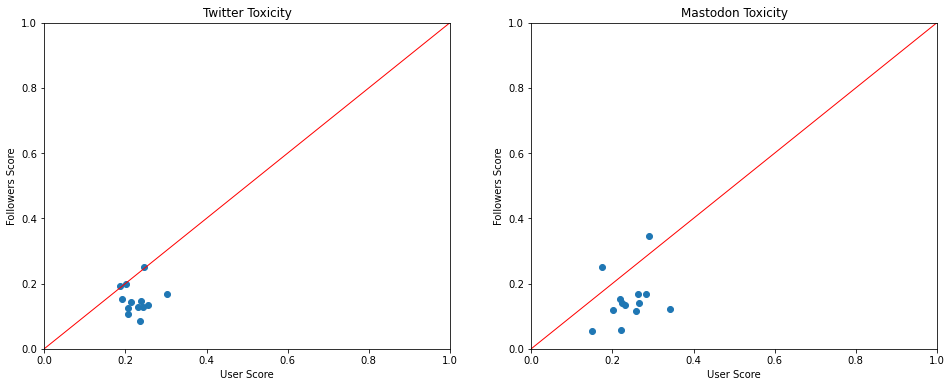

In [54]:
toxic_followers = pd.read_csv('toxic_followers_scores.csv', index_col = None)


#print(toxic_followers[toxic_followers["twitter_username"] == "francoiseleste"])
tw_x = []
tw_y = []

ma_x = []
ma_y = []

for idx, user in avg_toxic_scores.iterrows():
    #print(user["twitter_username"])
    foll_score = toxic_followers[toxic_followers["twitter_username"] == user["twitter_username"]]
    if(idx == 4):
        continue


    tw_x.append(user["Twitter_TOXICITY"])
    tw_y.append(foll_score["Twitter_TOXICITY"].values[0])
    
    ma_x.append(user["Mastodon_TOXICITY"])
    ma_y.append(foll_score["Mastodon_TOXICITY"].values[0])

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(tw_x,tw_y, vmax=1, vmin=0,)
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].axline((0,0),(1,1), linewidth=1, color='r')
ax[0].set_title('Twitter Toxicity')
ax[0].set_xlabel('User Score')
ax[0].set_ylabel('Followers Score')


ax[1].scatter(ma_x,ma_y, vmax=1, vmin=0,)
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].axline((0,0),(1,1), linewidth=1, color='r')
ax[1].set_title('Mastodon Toxicity')
ax[1].set_xlabel('User Score')
ax[1].set_ylabel('Followers Score')



### Non-Toxic Users

Let's now do the same thing but for non-toxic users!  
Outputs of the followers scraping process are removed as they are way too long and unnecessary.


In [81]:
_sorted_tw_scores = tw['mean_score'].sort_values()
_sorted_ma_scores = ma['mean_score'].sort_values()

non_toxic_tw_users = _sorted_tw_scores[:56]
non_toxic_ma_users = _sorted_ma_scores[:56]

common_nt_ma = non_toxic_ma_users.index.intersection(non_toxic_tw_users.index)
common_nt_tw = non_toxic_tw_users.index.intersection(non_toxic_ma_users.index)

print('toxic users in common: ', len(common_nt_ma)) # 14 users in common!

nt_users = users.loc[users['twitter_username'].isin(tw.loc[common_nt_tw]['twitter_username'])]
nt_users_scores = scores.loc[scores['twitter_username'].isin(nt_users['twitter_username'])]


toxic users in common:  19


In [39]:
'''
os.mkdir('./non_toxic_accounts_followers')
os.mkdir('./non_toxic_accounts_followers/twitter')
os.mkdir('./non_toxic_accounts_followers/mastodon')
'''

In [107]:
for idx, user in nt_users.iterrows():
    
    # limit users we process to those that were findable on mastodon
    if (not user["twitter_id"] in [20715956, 28180275, 51954111, 130596773,
                                   158080115, 250339392, 790500578, 886442904,
                                   1079889008, 1657794571, 2865352137, 4425367816,
                                   4533675376, 928901002308280320, 1009886503156273152,
                                   1399446292779175938, 4425367816]):
        continue
    
    if(Path(f'./non_toxic_accounts_followers/twitter/{user["twitter_id"]}.json').is_file() ):
        print("file already exists..")
        continue
    results = query_user_followers(str(user['twitter_id']))
    if(not results):
        continue
    print(f'User { user["twitter_username"] } has {len(results)} followers')
    with open(f'./non_toxic_accounts_followers/twitter/{user["twitter_id"]}.json', 'w+') as json_file:
        json.dump(results, json_file)
    

file already exists..
file already exists..
User LaCasaInvisible has 1000 followers
User PrincetonUPress has 1000 followers
User g3ndr0id has 19 followers
User BotRhb has 1000 followers
User GliScarabocchi has 1000 followers
User opreismetco has 1000 followers
User florianbrochard has 445 followers
User BE_bilingue has 1000 followers
User HLBurdett has 1000 followers
file already exists..
User gijn has 999 followers
User MPE_13 has 212 followers
User EvelyneJardin has 1000 followers
User WTIunibe has 1000 followers


In [89]:
for idx, user in nt_users.iterrows():
    if(Path(f'./non_toxic_accounts_followers/mastodon/{user["twitter_id"]}.json').is_file() ):
        print("file already exists..")
        continue
    results = query_mastodon_followers(str(user['mastodon_username']))    
    if(not results):
        continue
    print(f'User { user["twitter_username"] } has {len(results)} followers on mastodon')
    
    with open(f'./non_toxic_accounts_followers/mastodon/{user["twitter_id"]}.json', 'w+') as json_file:
        json.dump(results, json_file)

file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
file already exists..
User HLBurdett has 69 followers on mastodon
file already exists..
User gijn has 137 followers on mastodon
User MPE_13 has 2 followers on mastodon
User EvelyneJardin has 82 followers on mastodon
User WTIunibe has 55 followers on mastodon


In [ ]:
process_mastodon_followers('./non_toxic_accounts_followers/mastodon', './non_toxic_followers_posts/mastodon_posts')

In [ ]:
process_twitter_followers('./non_toxic_accounts_followers/twitter', './non_toxic_followers_posts/tweets')

In [116]:
with open('./non_toxic_followers_scores.csv', 'w+') as scores_file :
    scores_file.write('twitter_id,twitter_username,mastodon_username,Twitter_TOXICITY,Twitter_SEVERE_TOXICITY,Twitter_IDENTITY_ATTACK,Twitter_INSULT,Twitter_PROFANITY,Twitter_THREAT,Mastodon_TOXICITY,Mastodon_SEVERE_TOXICITY,Mastodon_IDENTITY_ATTACK,Mastodon_INSULT,Mastodon_PROFANITY,Mastodon_THREAT')

In [123]:
nt_users

,twitter_username,twitter_id,mastodon_username
73,charlesroduit,4425367816,https://mastodon.social/@protonmail/1074218548...
86,CalebdGM,790500578,https://thecanadian.social/@WaterlooEvents
134,openframeworks,28180275,https://fosstodon.org/@openFrameworks
208,LaCasaInvisible,158080115,https://culturaeinnovacion.social/@lacasainvis...
226,PrincetonUPress,20715956,https://mstdn.party/@PrincetonUPress
230,g3ndr0id,928901002308280320,https://androiddev.social/@Gendroid
256,BotRhb,1009886503156273152,https://mastodonapp.uk/@botrhb
264,GliScarabocchi,886442904,https://livellosegreto.it/@maicolemirco/
302,opreismetco,4533675376,https://mastodon.nl/@opreismetco/1093691141446...
306,florianbrochard,51954111,https://mastodon.florianbrochard.fr/@florian


In [128]:
# 4. now for each of them we process followers
for idx, nt_user in nt_users.iterrows():
    
    # define scores
    mastodon_scores = []
    twitter_scores = []
    
    # save current user data
    twitter_username, twitter_id, mastodon_username, *_  = nt_user
    if(twitter_id in [121026820, 1157616277269241862, 1253267702384406529,234757100]):
        continue
    # define languages otherwise perspective might get confused
    languages = {}
    # 1. mastodon
    mastodon_followers = list(glob.glob(f'non_toxic_followers_posts/mastodon_posts/{twitter_id}/**'))
    
    for follower_path in tqdm(mastodon_followers):
        id = follower_path.split('/')[-1]
        languages[id] = set()
        
        # define this scores
        foll_mastodon_scores = []
        # 1. extract posts
        posts = list(glob.glob(f"{follower_path}/**.json"))
        # 2. for each post retrieve score
        for post in posts :
            # read post
            with open(post, 'r+') as post_file:
                post_json = json.load(post_file)
            # extract content
            text = post_json['content']
            # extract language
            languages[id].add(post_json['language'])
            # query perspective
            scores = query_perspective(text=text, languages = list(languages[id]))
            
            if(not scores):
                continue
            # append scores
            foll_mastodon_scores.append({
                'TOXICITY': scores['TOXICITY']['summaryScore']['value'],
                    'SEVERE_TOXICITY': scores['SEVERE_TOXICITY']['summaryScore']['value'],
                    'IDENTITY_ATTACK' : scores[ 'IDENTITY_ATTACK' ]['summaryScore']['value'],
                    'INSULT': scores['INSULT']['summaryScore']['value'],
                    'PROFANITY' : scores[ 'PROFANITY' ]['summaryScore']['value'],
                    'THREAT' : scores[ 'THREAT' ]['summaryScore']['value']
            })
            
        # compute average score of follower
        sums = Counter()
        counters = Counter()
        for itemset in foll_mastodon_scores:
            sums.update(itemset)
            counters.update(itemset.keys())

        mastodon_scores.append({x: float(sums[x])/counters[x] for x in sums.keys()})
           
    
    # 2. twitter
    twitter_followers = list(glob.glob(f'./non_toxic_followers_posts/tweets/{twitter_id}/**'))
    for follower_path in tqdm(twitter_followers):
        id = follower_path.split('/')[-1]
        # define this follower scores
        foll_twitter_scores = []
        # 1. extract tweets
        files = list(glob.glob(f'{follower_path}/**.json'))
        # 2. for each tweet retrieve score
        for tweet in files :
            # read tweet
            with open(tweet, 'r+') as tweet_file:
                tweet_json = json.load(tweet_file)
            # extract content
            text = tweet_json['text']
            # retrieve score from perspective
            scores = query_perspective(text=text)
            if(not scores):
                continue
            # append scores
            foll_twitter_scores.append(
                {
                'TOXICITY': scores['TOXICITY']['summaryScore']['value'],
                'SEVERE_TOXICITY': scores['SEVERE_TOXICITY']['summaryScore']['value'],
                'IDENTITY_ATTACK' : scores['IDENTITY_ATTACK']['summaryScore']['value'],
                'INSULT': scores['INSULT']['summaryScore']['value'],
                'PROFANITY' : scores['PROFANITY']['summaryScore']['value'],
                'THREAT' : scores['THREAT']['summaryScore']['value']
            })
            
        # compute this follower scores
        sums = Counter()
        counters = Counter()
        for itemset in foll_twitter_scores:
            sums.update(itemset)
            counters.update(itemset.keys())

        twitter_scores.append({x: float(sums[x])/counters[x] for x in sums.keys()})
    
    # compute total mastodon avg score 
    sums = Counter()
    counters = Counter()
    for itemset in mastodon_scores:
        sums.update(itemset)
        counters.update(itemset.keys())

    mastodon_scores = {x: float(sums[x])/counters[x] for x in sums.keys()}
     
     
    # compute total twitter avg score 
    sums = Counter()
    counters = Counter()
    for itemset in twitter_scores:
        sums.update(itemset)
        counters.update(itemset.keys())

    twitter_scores = {x: float(sums[x])/counters[x] for x in sums.keys()}
     
    print(mastodon_scores)
    print(twitter_scores)
    if(not (twitter_scores.get('TOXICITY') and mastodon_scores.get('TOXICITY')) ):
        print(f"Breaking because we don't have scores...")
        continue
    with open('./non_toxic_followers_scores.csv', 'a+') as scores_file :
        scores_file.write(f"\n{twitter_id},{twitter_username},{mastodon_username},{twitter_scores['TOXICITY']},{twitter_scores['SEVERE_TOXICITY']},{twitter_scores['IDENTITY_ATTACK']},{twitter_scores['INSULT']},{twitter_scores['PROFANITY']},{twitter_scores['THREAT']},{mastodon_scores['TOXICITY']},{mastodon_scores['SEVERE_TOXICITY']},{mastodon_scores['IDENTITY_ATTACK']},{mastodon_scores['INSULT']},{mastodon_scores['PROFANITY']},{mastodon_scores['THREAT']}")
        

            
     

4425367816


100%|██████████| 280/280 [02:04<00:00,  2.25it/s]
0it [00:00, ?it/s]


{'TOXICITY': 0.07269209684793905, 'SEVERE_TOXICITY': 0.026678685468926374, 'IDENTITY_ATTACK': 0.027833335435257213, 'INSULT': 0.05196605358970711, 'PROFANITY': 0.05327160951576766, 'THREAT': 0.04347162104847621}
{}
Breaking because we don't have scores...
790500578


 90%|█████████ | 45/50 [09:36<01:01, 12.27s/it]

Catched an exception not dealt with.. we will print and then sleep and resume after 61 seconds. 
Exception : 
The read operation timed out
Skipping to next


100%|██████████| 50/50 [28:52<00:00, 34.65s/it] 


{'TOXICITY': 0.07002939934212736, 'SEVERE_TOXICITY': 0.005271683480625649, 'IDENTITY_ATTACK': 0.011701391729359065, 'INSULT': 0.03858444503854372, 'PROFANITY': 0.03908757362635885, 'THREAT': 0.013967758169690349}
{'TOXICITY': 0.05587833831557214, 'SEVERE_TOXICITY': 0.006160542752732261, 'IDENTITY_ATTACK': 0.019004261290026282, 'INSULT': 0.027999712773705086, 'PROFANITY': 0.03329367451408431, 'THREAT': 0.0151398910827931}
28180275


100%|██████████| 50/50 [06:18<00:00,  7.57s/it]


{'TOXICITY': 0.0562938976374718, 'SEVERE_TOXICITY': 0.011191754321016437, 'IDENTITY_ATTACK': 0.01749721022154042, 'INSULT': 0.032024276167197406, 'PROFANITY': 0.04032926960409622, 'THREAT': 0.02498350489450842}
{'TOXICITY': 0.05113094901770087, 'SEVERE_TOXICITY': 0.010252233498311477, 'IDENTITY_ATTACK': 0.012205787288365782, 'INSULT': 0.030676191443853456, 'PROFANITY': 0.04263590694207729, 'THREAT': 0.015848597490952215}
158080115


100%|██████████| 50/50 [07:36<00:00,  9.12s/it]


{'TOXICITY': 0.051185962654026244, 'SEVERE_TOXICITY': 0.009762339561158429, 'IDENTITY_ATTACK': 0.015334732262921447, 'INSULT': 0.039625785646741386, 'PROFANITY': 0.04355721902288259, 'THREAT': 0.016089278230006547}
{'TOXICITY': 0.08316965866924392, 'SEVERE_TOXICITY': 0.01845308451937834, 'IDENTITY_ATTACK': 0.02803045072529472, 'INSULT': 0.0662940523601167, 'PROFANITY': 0.0649112727699242, 'THREAT': 0.018536431065728737}
20715956


100%|██████████| 50/50 [06:59<00:00,  8.40s/it]


{'TOXICITY': 0.06398709763684146, 'SEVERE_TOXICITY': 0.011372711417158649, 'IDENTITY_ATTACK': 0.024129496491640607, 'INSULT': 0.036808990607674674, 'PROFANITY': 0.04064393090112154, 'THREAT': 0.02596059135165184}
{'TOXICITY': 0.06754057730143702, 'SEVERE_TOXICITY': 0.006921131927902217, 'IDENTITY_ATTACK': 0.026054805700847866, 'INSULT': 0.03940057768309345, 'PROFANITY': 0.04207924533875229, 'THREAT': 0.01874513896113128}
928901002308280320


100%|██████████| 13/13 [01:37<00:00,  7.47s/it]


{'TOXICITY': 0.07362770076875, 'SEVERE_TOXICITY': 0.00328183180625, 'IDENTITY_ATTACK': 0.004759427387499999, 'INSULT': 0.0562594348875, 'PROFANITY': 0.042286043125000006, 'THREAT': 0.00811499775}
{'TOXICITY': 0.031237657882822158, 'SEVERE_TOXICITY': 0.0025567820050292557, 'IDENTITY_ATTACK': 0.006255581940617808, 'INSULT': 0.017683986980676046, 'PROFANITY': 0.0269066143453117, 'THREAT': 0.008244796427495888}
1009886503156273152


100%|██████████| 50/50 [07:29<00:00,  9.00s/it]


{'TOXICITY': 0.057680661366545614, 'SEVERE_TOXICITY': 0.0034459815476129874, 'IDENTITY_ATTACK': 0.009448389413738413, 'INSULT': 0.03252841422711445, 'PROFANITY': 0.03474214115546311, 'THREAT': 0.01159352699448752}
{'TOXICITY': 0.07316600919006, 'SEVERE_TOXICITY': 0.008797587154587715, 'IDENTITY_ATTACK': 0.013659996361843556, 'INSULT': 0.04032227068507429, 'PROFANITY': 0.05146379656735728, 'THREAT': 0.015983125456942717}
886442904


100%|██████████| 50/50 [05:55<00:00,  7.10s/it]


{'TOXICITY': 0.059684475983240774, 'SEVERE_TOXICITY': 0.004818965579571983, 'IDENTITY_ATTACK': 0.010974268279861834, 'INSULT': 0.03551517703230393, 'PROFANITY': 0.038663351180604044, 'THREAT': 0.012309683184893661}
{'TOXICITY': 0.09727872658116335, 'SEVERE_TOXICITY': 0.014413784793177634, 'IDENTITY_ATTACK': 0.01976566581911503, 'INSULT': 0.07182204787133145, 'PROFANITY': 0.07305746879840726, 'THREAT': 0.017909080466275356}
4533675376


100%|██████████| 50/50 [06:09<00:00,  7.40s/it]


{'TOXICITY': 0.012950600741434929, 'SEVERE_TOXICITY': 0.004108910948565297, 'IDENTITY_ATTACK': 0.005141841834492229, 'INSULT': 0.010339558668841044, 'PROFANITY': 0.018437739172222224, 'THREAT': 0.00592948360406167}
{'TOXICITY': 0.030082555788140723, 'SEVERE_TOXICITY': 0.006818550047874478, 'IDENTITY_ATTACK': 0.007384591309922861, 'INSULT': 0.019374236023417306, 'PROFANITY': 0.03244012570322031, 'THREAT': 0.009507749494124468}
51954111


100%|██████████| 50/50 [06:13<00:00,  7.47s/it]


{'TOXICITY': 0.023494402429074072, 'SEVERE_TOXICITY': 0.0013042726231375663, 'IDENTITY_ATTACK': 0.0026930964793730155, 'INSULT': 0.014444960124523808, 'PROFANITY': 0.018679559468386245, 'THREAT': 0.006850735252248677}
{'TOXICITY': 0.03989081225342606, 'SEVERE_TOXICITY': 0.0040806067449363406, 'IDENTITY_ATTACK': 0.006068743322614173, 'INSULT': 0.021876484113549713, 'PROFANITY': 0.0358459166847513, 'THREAT': 0.010090581618102896}
10495792


0it [00:00, ?it/s]
0it [00:00, ?it/s]


{}
{}
Breaking because we don't have scores...
1079889008


100%|██████████| 50/50 [07:36<00:00,  9.12s/it]


{'TOXICITY': 0.0464111029968418, 'SEVERE_TOXICITY': 0.010194869208836018, 'IDENTITY_ATTACK': 0.017970602425554715, 'INSULT': 0.02682203863886592, 'PROFANITY': 0.030686243554177036, 'THREAT': 0.026624059873097124}
{'TOXICITY': 0.035828167560078346, 'SEVERE_TOXICITY': 0.007148060764220765, 'IDENTITY_ATTACK': 0.01476961823853946, 'INSULT': 0.022204533807884164, 'PROFANITY': 0.026311684318456433, 'THREAT': 0.017416820786626076}
1657794571


100%|██████████| 50/50 [07:35<00:00,  9.10s/it]


{'TOXICITY': 0.03958307888505339, 'SEVERE_TOXICITY': 0.004956806366114304, 'IDENTITY_ATTACK': 0.011720378060871697, 'INSULT': 0.02209478063915802, 'PROFANITY': 0.027288879579202816, 'THREAT': 0.01734855566842227}
{'TOXICITY': 0.028003884285175598, 'SEVERE_TOXICITY': 0.0026595187855492602, 'IDENTITY_ATTACK': 0.007524405539220939, 'INSULT': 0.01433725406151661, 'PROFANITY': 0.021665663979910564, 'THREAT': 0.01109698461133305}
158080115


100%|██████████| 50/50 [07:45<00:00,  9.32s/it]


{'TOXICITY': 0.051185962654026244, 'SEVERE_TOXICITY': 0.009762339561158429, 'IDENTITY_ATTACK': 0.015334732262921447, 'INSULT': 0.039625785646741386, 'PROFANITY': 0.04355721902288259, 'THREAT': 0.016089278230006547}
{'TOXICITY': 0.08316965866924392, 'SEVERE_TOXICITY': 0.018453084522305173, 'IDENTITY_ATTACK': 0.02803045072529472, 'INSULT': 0.06629405235792157, 'PROFANITY': 0.0649112727699242, 'THREAT': 0.018536431065728737}
130596773


100%|██████████| 50/50 [07:08<00:00,  8.58s/it]


{'TOXICITY': 0.06293307742550337, 'SEVERE_TOXICITY': 0.014893679649890489, 'IDENTITY_ATTACK': 0.027579252815221948, 'INSULT': 0.04275161637920879, 'PROFANITY': 0.03835987585275957, 'THREAT': 0.03344830351713131}
{'TOXICITY': 0.09269331782013215, 'SEVERE_TOXICITY': 0.025009178112285143, 'IDENTITY_ATTACK': 0.049013065406600546, 'INSULT': 0.0656820978632878, 'PROFANITY': 0.05745890042763293, 'THREAT': 0.04330596793820967}
1399446292779175938


100%|██████████| 50/50 [08:51<00:00, 10.62s/it]


{}
{'TOXICITY': 0.048595172133794995, 'SEVERE_TOXICITY': 0.006105354499941047, 'IDENTITY_ATTACK': 0.009415320050363973, 'INSULT': 0.048170932810490064, 'PROFANITY': 0.027434294561330702, 'THREAT': 0.007687039010786146}
Breaking because we don't have scores...
250339392


100%|██████████| 50/50 [08:58<00:00, 10.78s/it]


{'TOXICITY': 0.03565065880306871, 'SEVERE_TOXICITY': 0.00465341877836607, 'IDENTITY_ATTACK': 0.008223121692647205, 'INSULT': 0.03080113177768462, 'PROFANITY': 0.025579416132456807, 'THREAT': 0.011252135350469174}
{'TOXICITY': 0.029188491403586238, 'SEVERE_TOXICITY': 0.002354717879965829, 'IDENTITY_ATTACK': 0.005602743583991137, 'INSULT': 0.024619108083125663, 'PROFANITY': 0.02062306542591879, 'THREAT': 0.007033197089878187}
2865352137


100%|██████████| 50/50 [05:54<00:00,  7.08s/it]


{'TOXICITY': 0.054151673137810157, 'SEVERE_TOXICITY': 0.011413445282298519, 'IDENTITY_ATTACK': 0.02529707458000236, 'INSULT': 0.03877476165861017, 'PROFANITY': 0.029697972061765308, 'THREAT': 0.02839806636708972}
{'TOXICITY': 0.051098478947370574, 'SEVERE_TOXICITY': 0.004303509423960475, 'IDENTITY_ATTACK': 0.017729449919557255, 'INSULT': 0.02900631888196723, 'PROFANITY': 0.02982210198249643, 'THREAT': 0.01283953037402759}
76346033


0it [00:00, ?it/s]
0it [00:00, ?it/s]

{}
{}
Breaking because we don't have scores...
